# Classifier comparison on EFRI movement decoding task
We compare the performance of MORF against several other classifiers on raw stereo-EEG (sEEG) data. Patients in the EFRI cohort were tasked with using a manipulandum to maneuver a cursor from a central starting point to a target zone located either up, down, left, or right of center.

## Experimental Setup
The raw sEEG data is a multivariate time series of dimension $N \times C \times T$, where $N$ is the number of trials the task was performed, $C$ is the number of sEEG implantations, and $T$ is the number of time steps. Each patient typically performed around $N=75$ to $N=100$ trials of the experiment successfully and had $C=70$ to $C=100$ channel recordings. The time window in consideration begins -0.2 s before the recorded instance the patient leaves the central starting point until 0.5 s after they have left the central starting point. The sampling frequency was downsampled to 500 Hz, yielding $T = 350$. The labels are integer-encoded directions $\{0,1,2,3\}$ corresponding to down, right, up, and left, respectively.

We analyze the performance of several classifiers against MORF in this multi-class classification problem, primarily evaluating based on the macro-averaged one vs. rest area under the receiver operating curve (OvR AUROC). We show the results over 5-fold stratified cross validation.

by Chester Huynh and Adam Li, *March 2021*

In [65]:
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from mne_bids import BIDSPath
from ptitprince import RainCloud

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 20,
    "font.weight": "bold"
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
cohort = [
    # "efri02",
    # "efri06",
    "efri07",
    "efri13",
    # "efri14",
    "efri15",
    # "efri18",
    "efri20",
    # "efri25",
    # "efri26"
]

# Path to folder containing all subject results
derivatives_path = Path(
    "/Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output/mtmorf/decode_movement/"
)
# Mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
cohort_clf_scores = defaultdict(dict)
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(derivatives_path / f"{subject}/time_domain/{subject}_{clf_fname}_results.json", "r") as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

## Directionality decoding plots

In [83]:
import json
cohort = [
    # "efri02",
    # "efri06",
    "efri07",
    "efri13",
    "efri14",
    # "efri15",
    "efri18",
    "efri20",
    # "efri25",
    # "efri26"
]
derivatives_path = Path(
    "/Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output/mtmorf/decode_directionality/"
)

cohort_clf_scores = defaultdict(dict)

# Create mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(
            derivatives_path / f"{subject}/tmin=-0.2_tmax=0.5/time_domain/{subject}_{clf_fname}_results.json", "r"
        ) as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

In [84]:
def plot_directionality_comparison(cohort_clf_scores, metric="roc_auc_ovr"):
    if metric not in ["roc_auc_ovr", "accuracy", "cohen_kappa_score"]:
        raise ValueError("metric must be one of roc_auc_ovr, accuracy or cohen_kappa_score")

    palette = {
        "MORF": "blue",
        "SPORF": "orange",
        "MLP": "green",
        "SVM": "magenta",
        "Log. Reg": "black",
        "XGB": "red",
        "ConvNet": "gray",
        "Dummy": "brown",
        "RF": "teal",
        "kNN": "purple",
    }

    df = []
    for subject, clf_scores in cohort_clf_scores.items():
        for clf_name, scores in clf_scores.items():
            df.append([subject, clf_name, scores[f"test_{metric}"]])
    df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
    df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                            "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                            metric: np.concatenate(df[metric].values)})

    width = 8
    aspect_ratio = 3/4  # 4:3 aspect ratio
    fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300, facecolor='w')
    sns.stripplot(x="Classifier", y=metric, data=df, ax=ax, palette=palette)
    
    # Set labels and titles
    ylabel = {
        "roc_auc_ovr": "ROC AUC",
        "accuracy": "Accuracy",
        "cohen_kappa_score": "Cohen Kappa Score"
    }
    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=45, fontweight="bold", ha="right")
    ax.set_xlabel("Classifier", fontweight="bold")
    ax.set_ylabel(f"Cross-Validated {ylabel[metric]}", fontweight="bold")
    ax.set_title(f"Decoding Directionality from Raw sEEG Recordings", fontweight="bold")
    legendlabel = {
        "roc_auc_ovr": "ROC AUC (MORF)",
        "accuracy": "Accuracy (MORF)",
        "cohen_kappa_score": "Cohen Kappa Score (MORF)",
    }
    line = ax.axhline(
        np.median(df[df["Classifier"] == "MORF"][metric]), 
        label=f"Median {legendlabel[metric]}", ls="--", lw=2, c='r', alpha=0.7
    )

    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = df[df["Classifier"] == sample_name][metric].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot(
            [tick - median_width / 2, tick + median_width / 2],
            [median_val, median_val],
            lw=4,
            color="k",
        )

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.legend([line],[line.get_label()], frameon=False)
    return ax

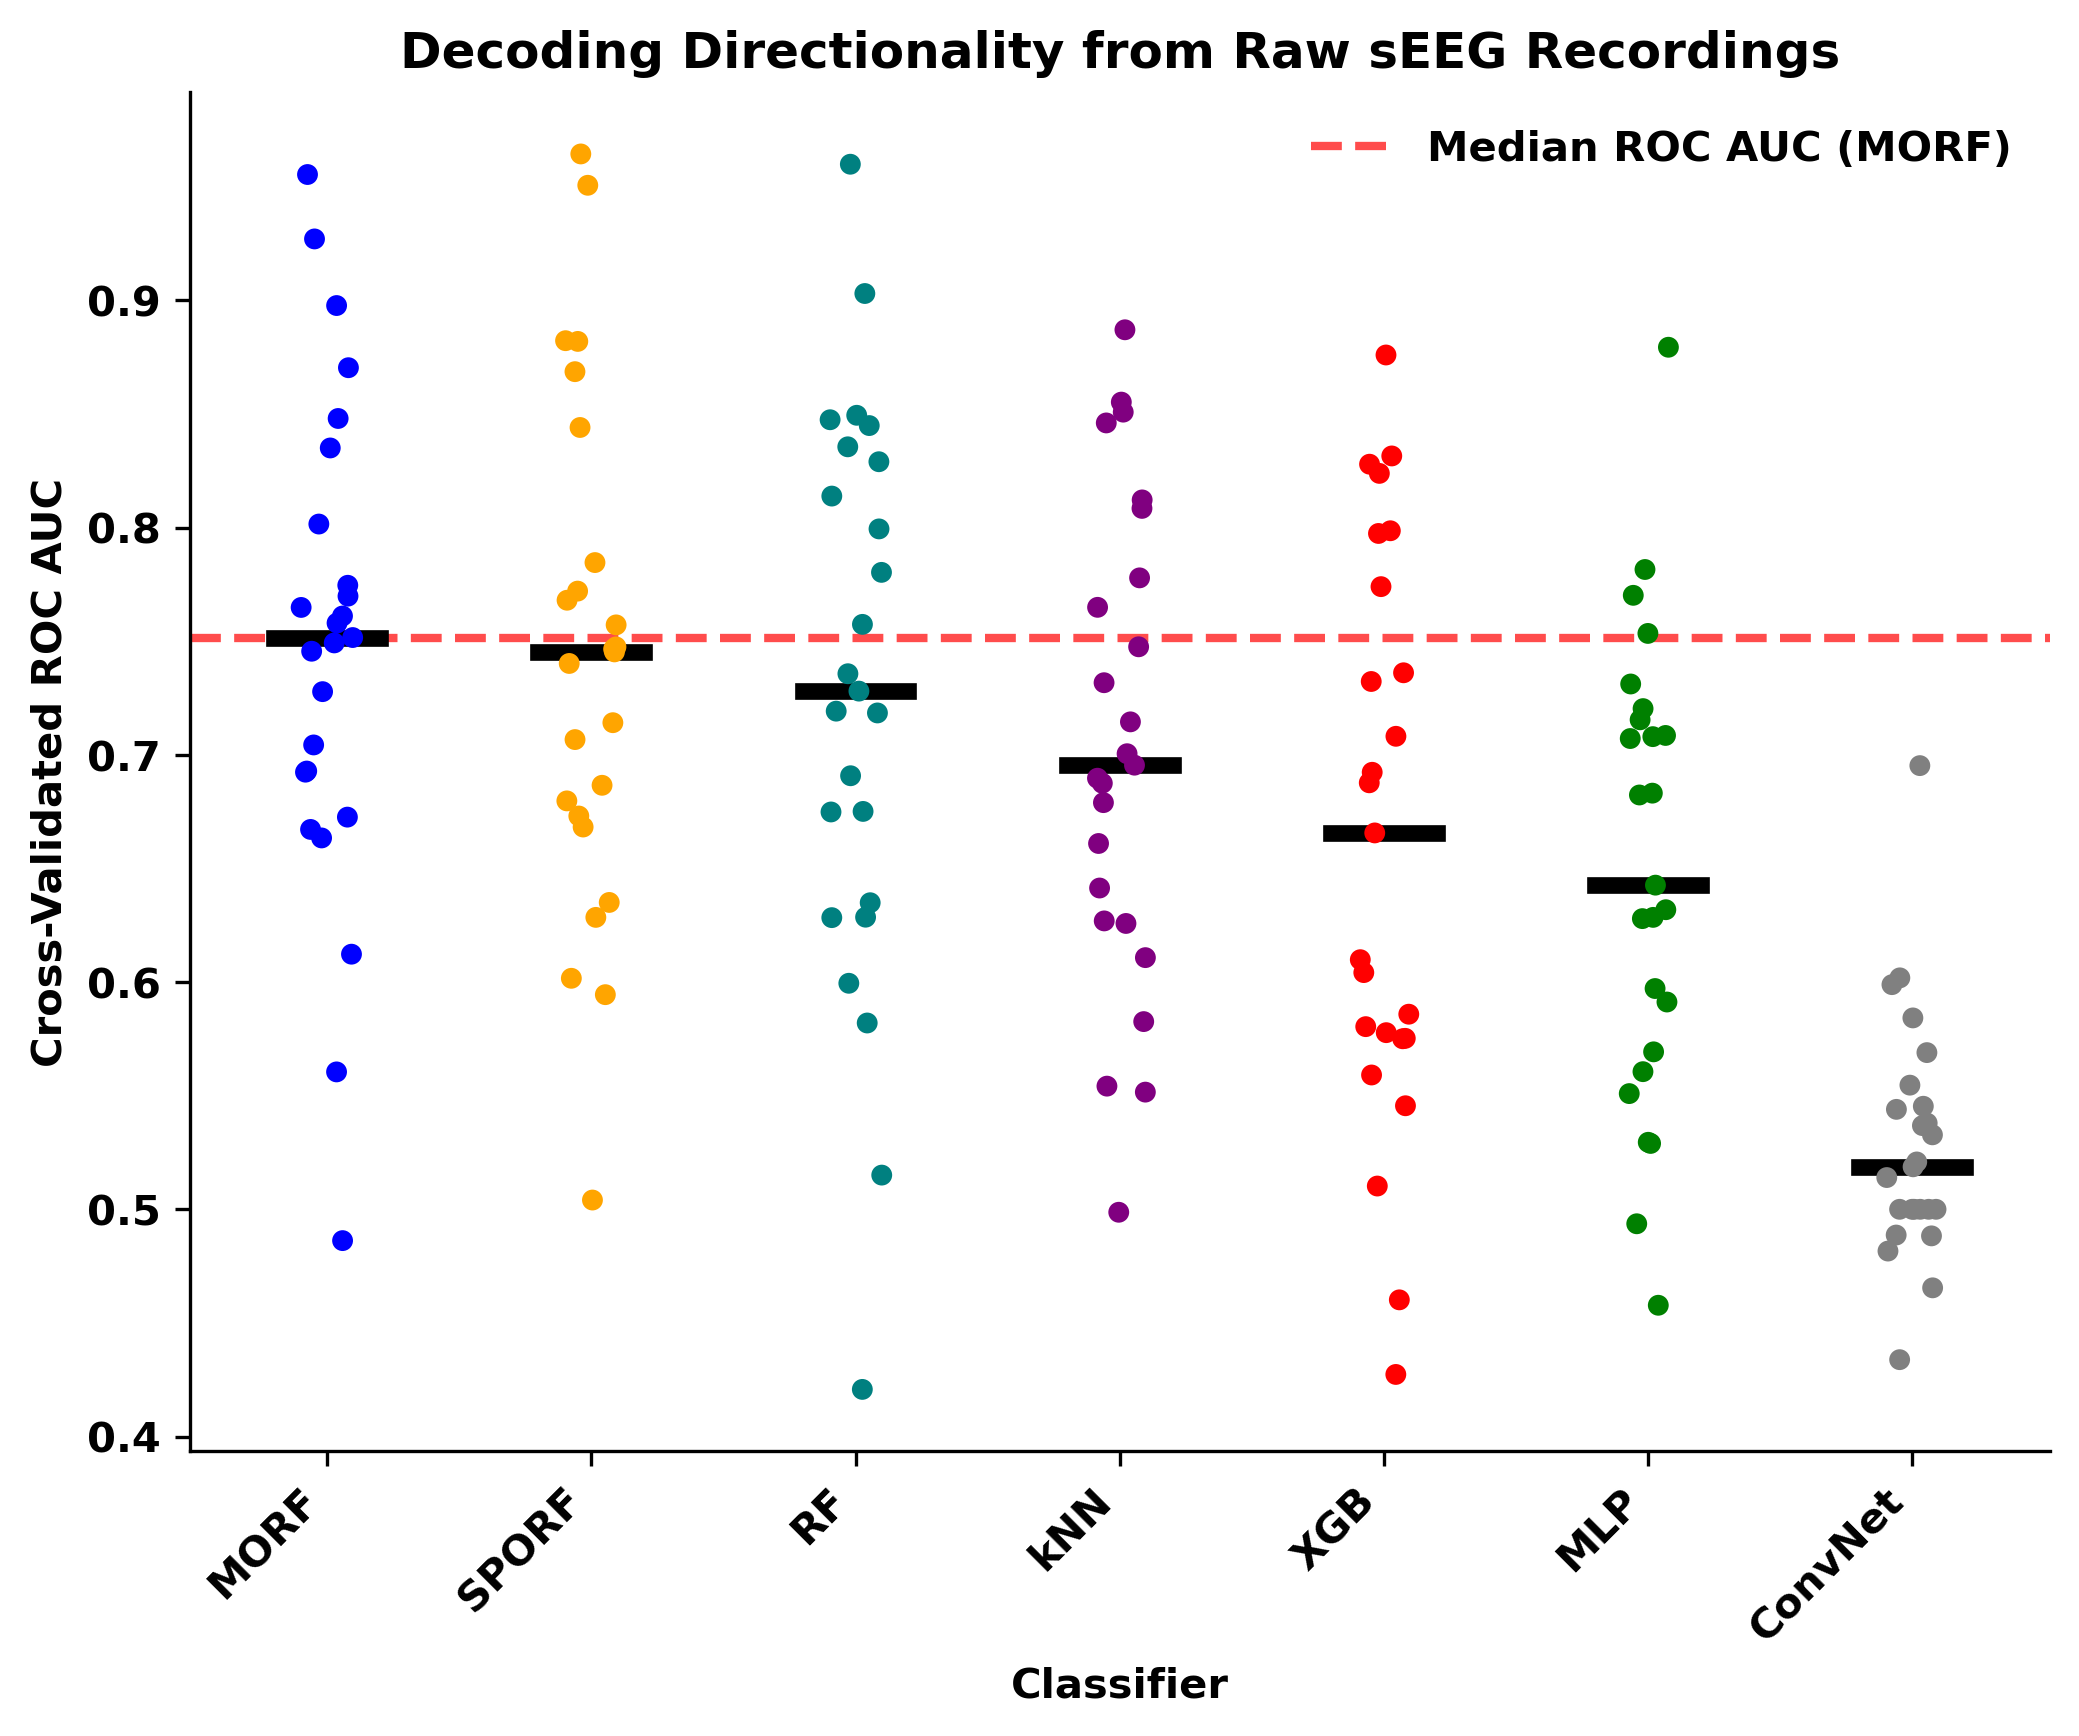

In [85]:
plot_directionality_comparison(cohort_clf_scores, "roc_auc_ovr")
plt.savefig("../figures/efri_directionality_decoding_auroc.png");

<AxesSubplot:title={'center':'Decoding Directionality from Raw sEEG Recordings'}, xlabel='Classifier', ylabel='Cross-Validated Accuracy'>

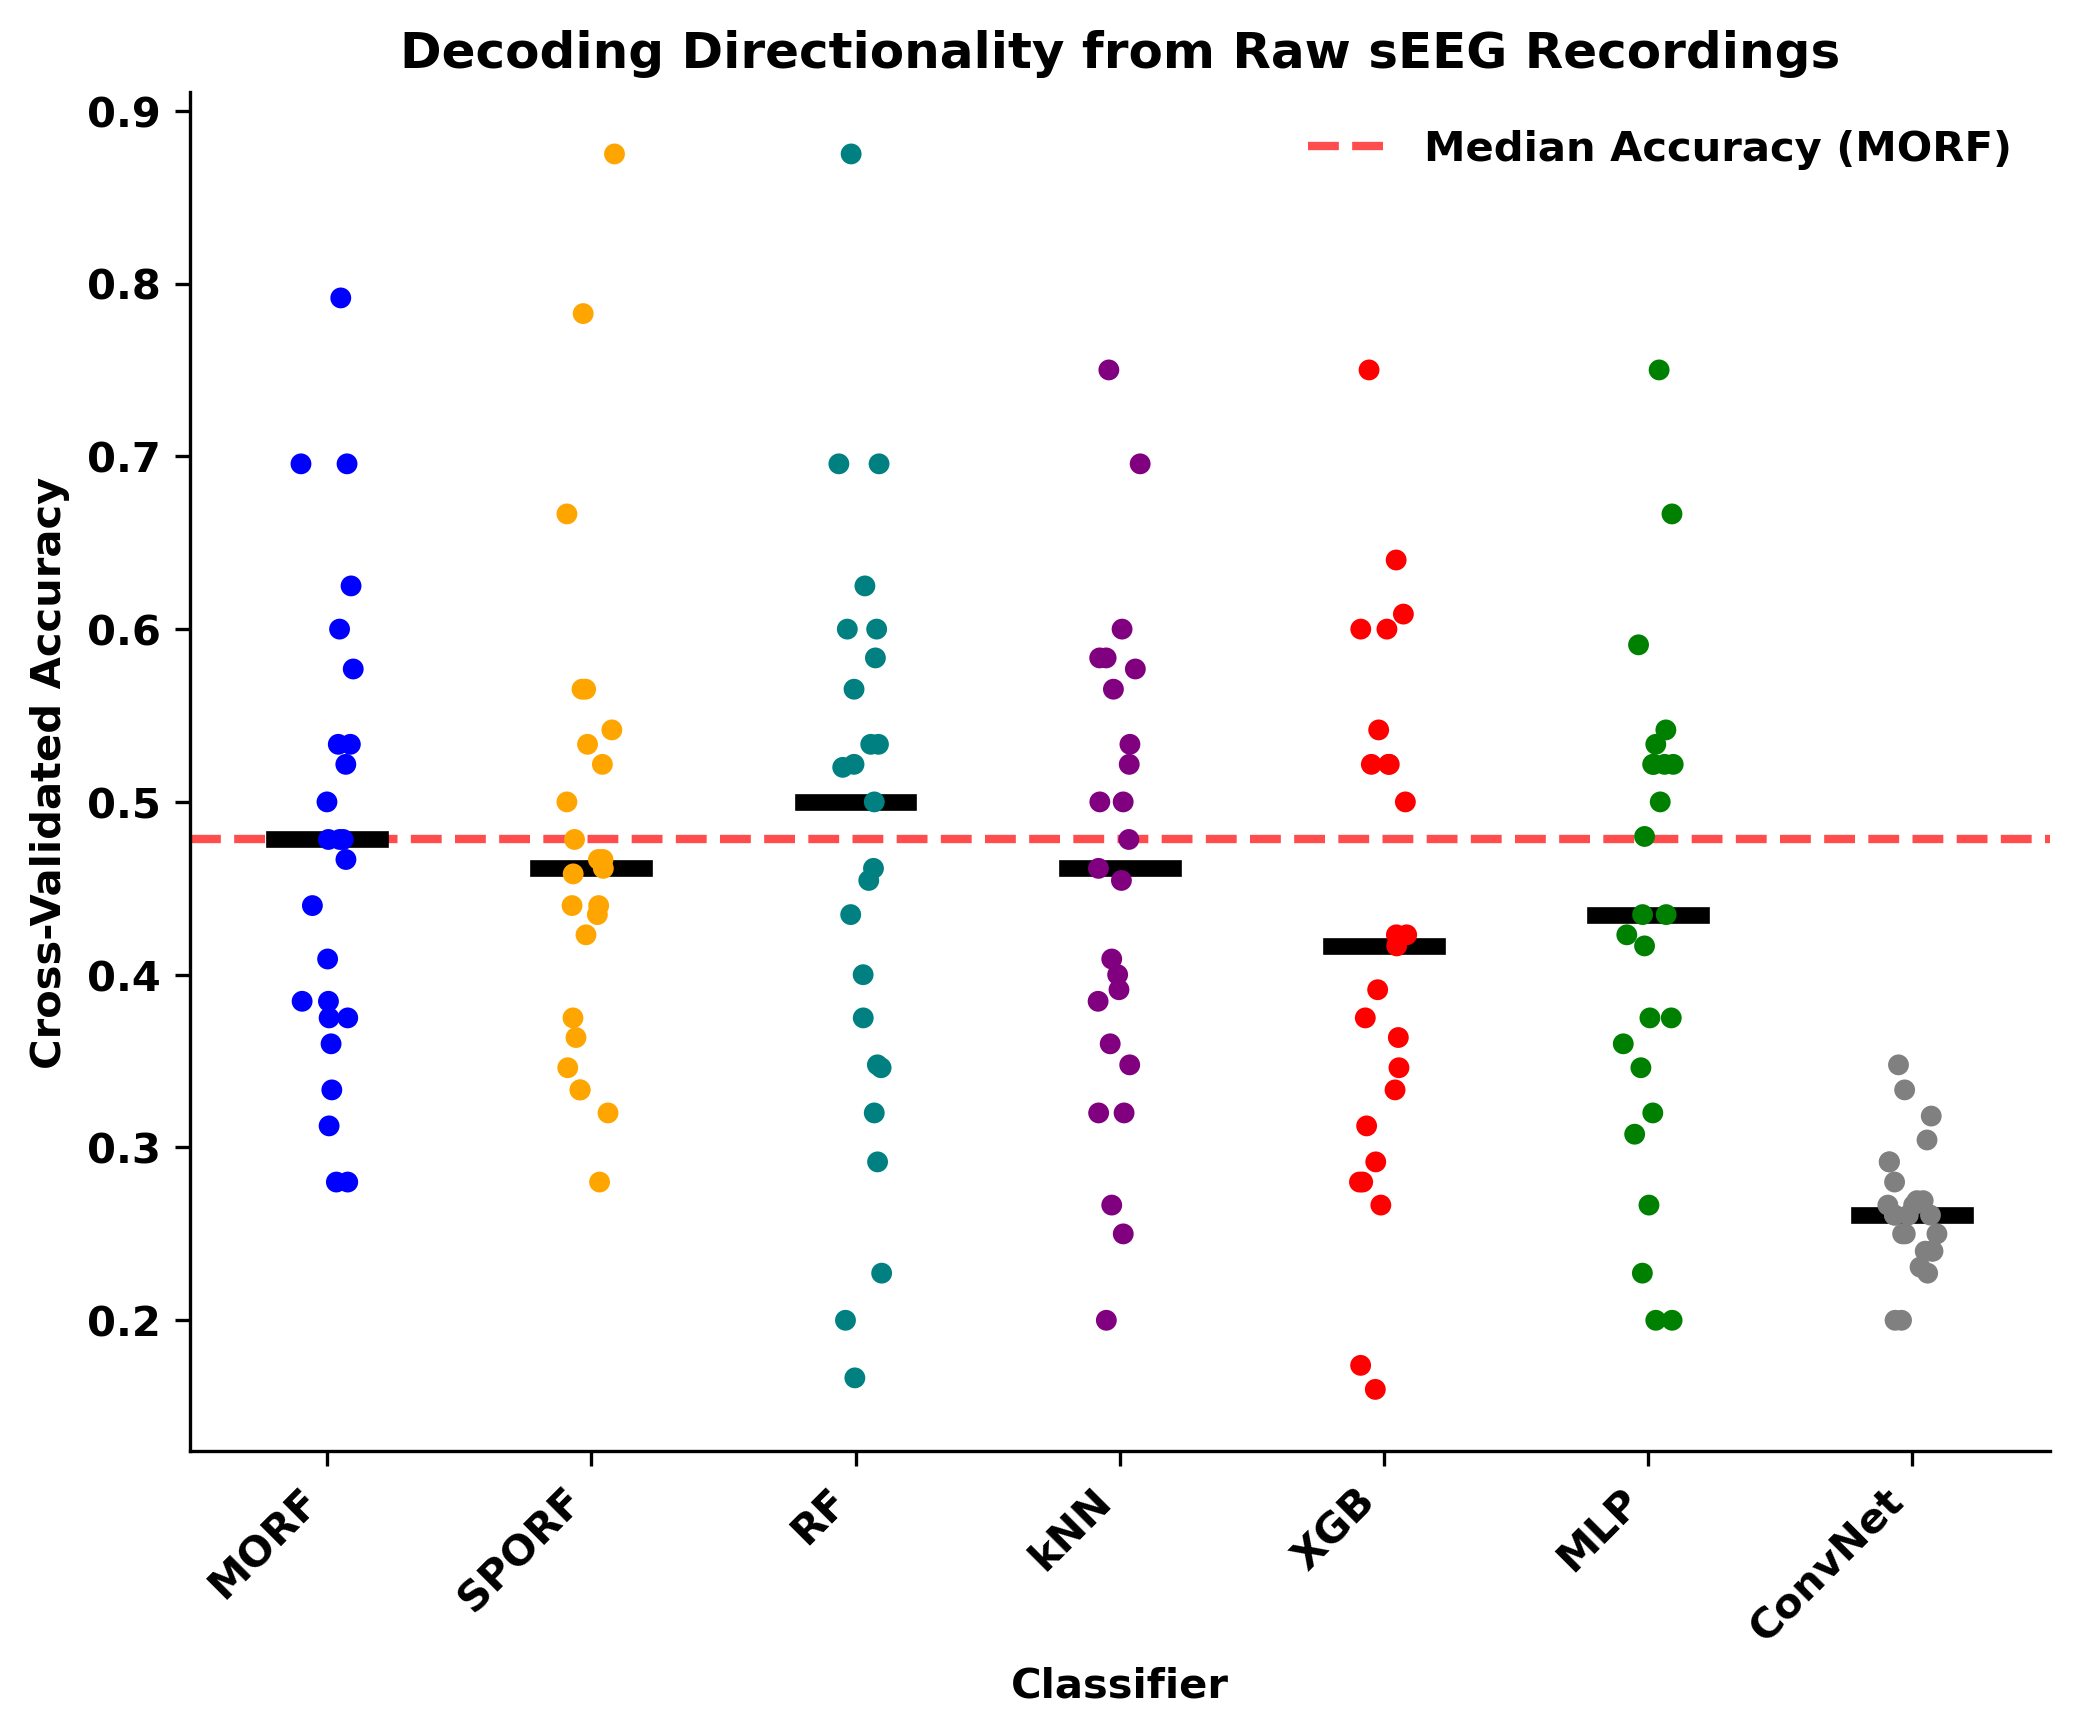

In [86]:
plot_directionality_comparison(cohort_clf_scores, "accuracy")

<AxesSubplot:title={'center':'Decoding Directionality from Raw sEEG Recordings'}, xlabel='Classifier', ylabel='Cross-Validated Cohen Kappa Score'>

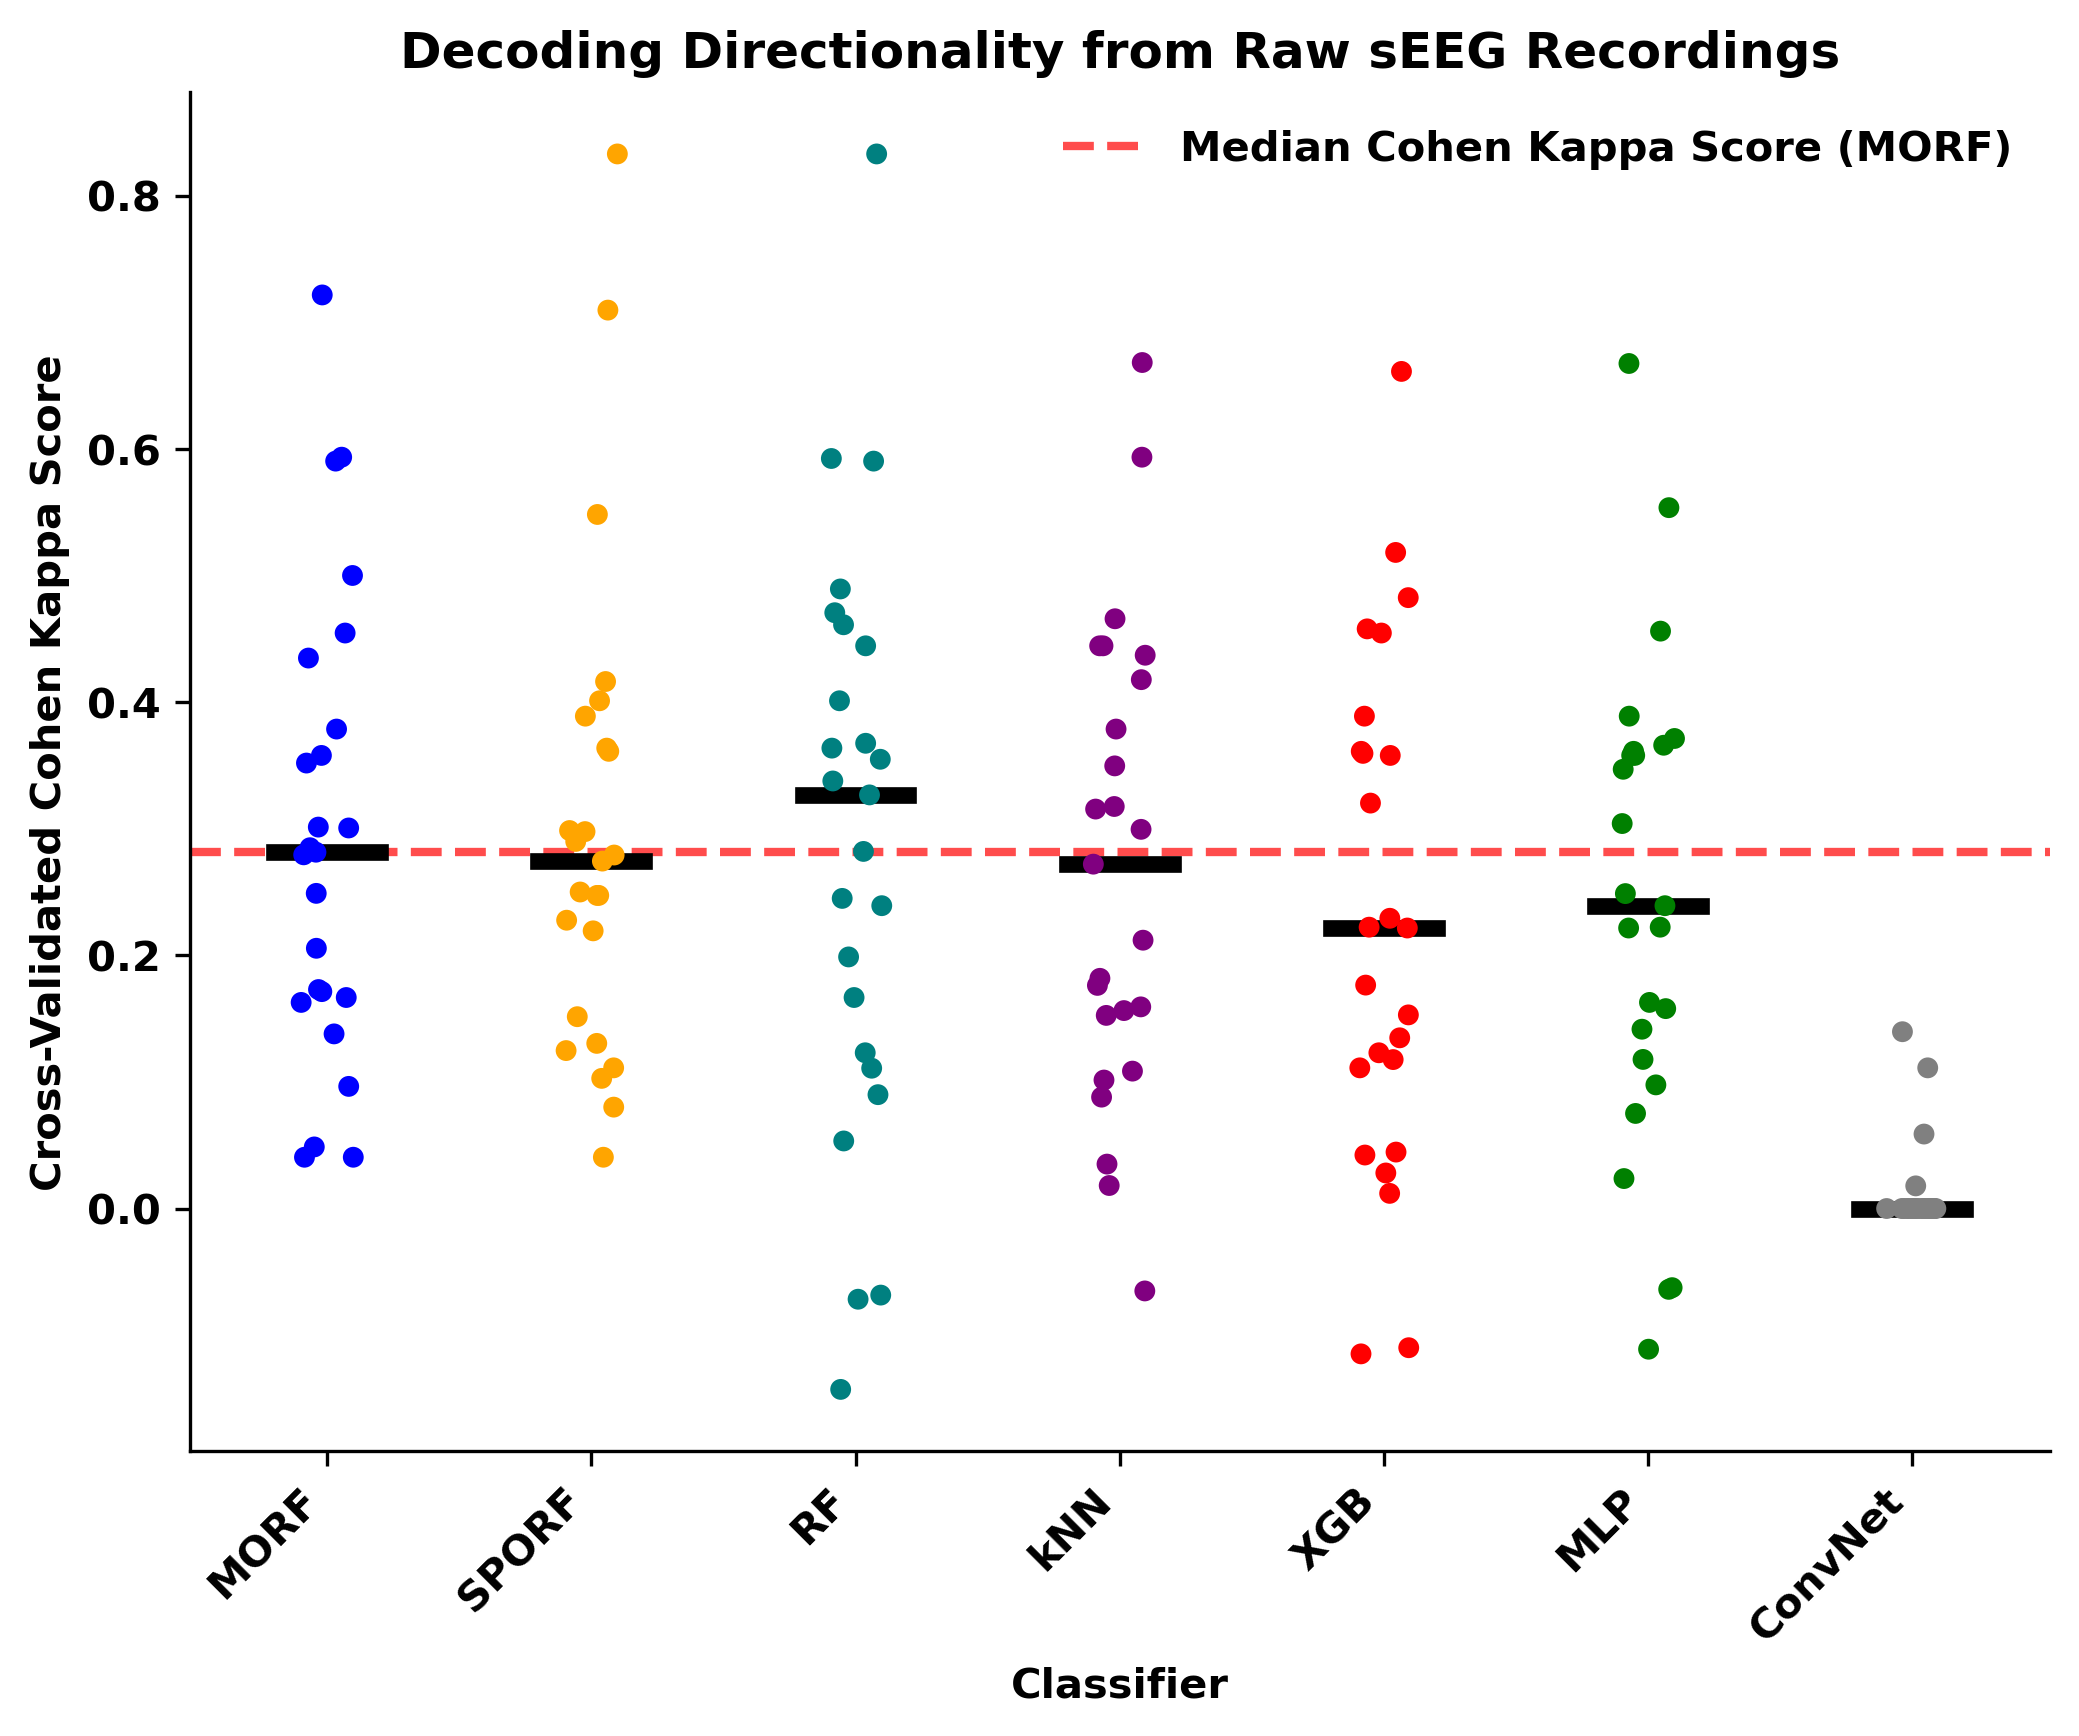

In [87]:
plot_directionality_comparison(cohort_clf_scores, "cohen_kappa_score")